In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Set visualization style
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# Load the datasets with a specific encoding to handle special characters
# We try 'ISO-8859-1' (also known as latin1) which usually fixes Excel export issues

try:
    bookings_df = pd.read_csv('cinnamon_bookings.csv', encoding='ISO-8859-1')
    feedback_df = pd.read_csv('cinnamon_feedback.csv', encoding='ISO-8859-1')
    profiles_df = pd.read_csv('customers_profiles .csv', encoding='ISO-8859-1')
    print("Files loaded successfully with ISO-8859-1 encoding!")
except UnicodeDecodeError:
    # Fallback if the above fails
    bookings_df = pd.read_csv('cinnamon_bookings.csv', encoding='cp1252')
    feedback_df = pd.read_csv('cinnamon_feedback.csv', encoding='cp1252')
    profiles_df = pd.read_csv('customers_profiles .csv', encoding='cp1252')
    print("Files loaded successfully with cp1252 encoding!")

# Quick check of the data
print("Bookings shape:", bookings_df.shape)
print("Feedback shape:", feedback_df.shape)
print("Profiles shape:", profiles_df.shape)

Files loaded successfully with ISO-8859-1 encoding!
Bookings shape: (15000, 25)
Feedback shape: (15177, 19)
Profiles shape: (5000, 11)


In [3]:
# 1. Aggregate Booking Data
# We want to know their spending habits, stay duration, and planning style.
booking_stats = bookings_df.groupby('customer_id').agg({
    'avg_daily_rate': 'mean',       # Spending power
    'nights_stay': 'mean',          # Average stay duration
    'lead_time_days': 'mean',       # Planning habit (early vs late)
    'is_cancelled': 'mean'          # Cancellation risk
}).rename(columns={
    'avg_daily_rate': 'avg_spend_per_night',
    'nights_stay': 'avg_nights_stay',
    'lead_time_days': 'avg_lead_time',
    'is_cancelled': 'cancellation_rate'
})

# 2. Aggregate Feedback Data
# We want to know their general satisfaction level.
feedback_stats = feedback_df.groupby('customer_id').agg({
    'overall_rating': 'mean'
}).rename(columns={'overall_rating': 'avg_overall_rating'})

In [4]:
# Start with the static customer profiles
customer_features = profiles_df[['customer_id', 'price_sensitivity', 'quality_expectations', 'travel_frequency']].copy()

# Merge with booking stats
customer_features = customer_features.merge(booking_stats, on='customer_id', how='left')

# Merge with feedback stats
customer_features = customer_features.merge(feedback_stats, on='customer_id', how='left')

# Drop rows with missing values (for this basic model)
# In a more advanced version, you might fill these with 0 or the mean.
customer_features_clean = customer_features.dropna()

print(f"Final dataset shape for clustering: {customer_features_clean.shape}")
print(customer_features_clean.head())

Final dataset shape for clustering: (4749, 9)
   customer_id  price_sensitivity  quality_expectations  travel_frequency  \
2  CUST-000003              0.505                 0.691                 6   
3  CUST-000004              0.118                 0.794                 8   
4  CUST-000005              0.524                 0.595                 3   
5  CUST-000006              0.760                 0.361                 4   
6  CUST-000007              0.936                 0.296                 4   

   avg_spend_per_night  avg_nights_stay  avg_lead_time  cancellation_rate  \
2           243.113333         6.666667      33.333333           0.333333   
3           375.764000         6.000000      91.000000           0.000000   
4           224.172500         3.000000      49.500000           0.000000   
5           133.703333         2.000000      49.333333           0.000000   
6           167.423333         1.666667      33.666667           0.000000   

   avg_overall_rating  
2   

In [5]:
# Select features for clustering
features_to_use = [
    'price_sensitivity', 
    'quality_expectations', 
    'travel_frequency', 
    'avg_spend_per_night', 
    'avg_nights_stay', 
    'avg_lead_time', 
    'avg_overall_rating'
]

X = customer_features_clean[features_to_use]

# Normalize the data (Scale to mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means Clustering (We found 4 clusters works well)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Assign the cluster labels back to our dataframe
customer_features_clean['Cluster'] = clusters

C:\Users\User\AppData\Local\Temp\ipykernel_21472\2493109434.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_features_clean['Cluster'] = clusters


In [6]:
# Group by cluster to see the average values for each feature
segment_profile = customer_features_clean.groupby('Cluster')[features_to_use].mean()
print(segment_profile)

# Count how many customers are in each cluster
print("\nCluster Sizes:")
print(customer_features_clean['Cluster'].value_counts())

         price_sensitivity  quality_expectations  travel_frequency  \
Cluster                                                              
0                 0.326150              0.744595         10.560403   
1                 0.565894              0.596370          4.729888   
2                 0.824114              0.326343          3.548017   
3                 0.263453              0.818003          9.612188   

         avg_spend_per_night  avg_nights_stay  avg_lead_time  \
Cluster                                                        
0                 378.240789         5.422661      69.030714   
1                 194.572623         2.666905      59.094821   
2                 132.781344         1.672702      24.921862   
3                 389.126175         5.185208      74.956340   

         avg_overall_rating  
Cluster                      
0                  3.963051  
1                  3.756013  
2                  3.958338  
3                  3.407991  

Cluster Sizes

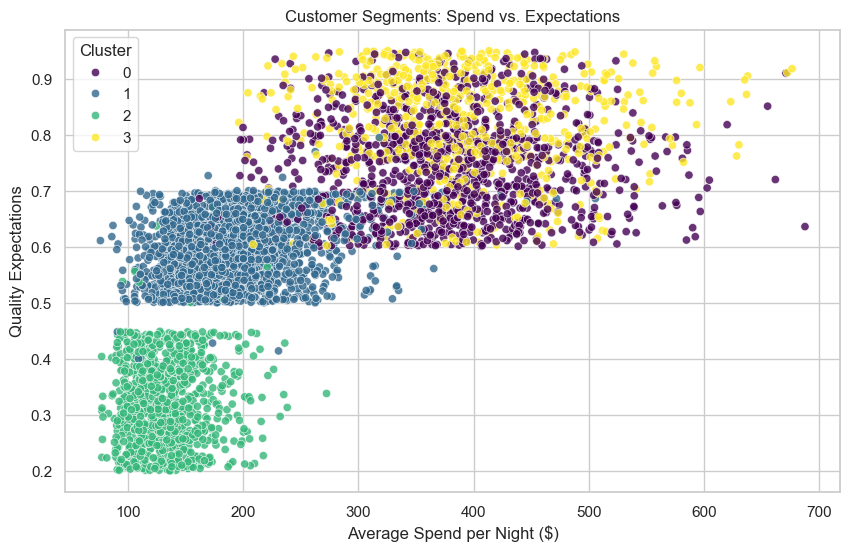

C:\Users\User\AppData\Local\Temp\ipykernel_21472\3835884083.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_features_clean, x='Cluster', y='avg_overall_rating', palette='viridis')


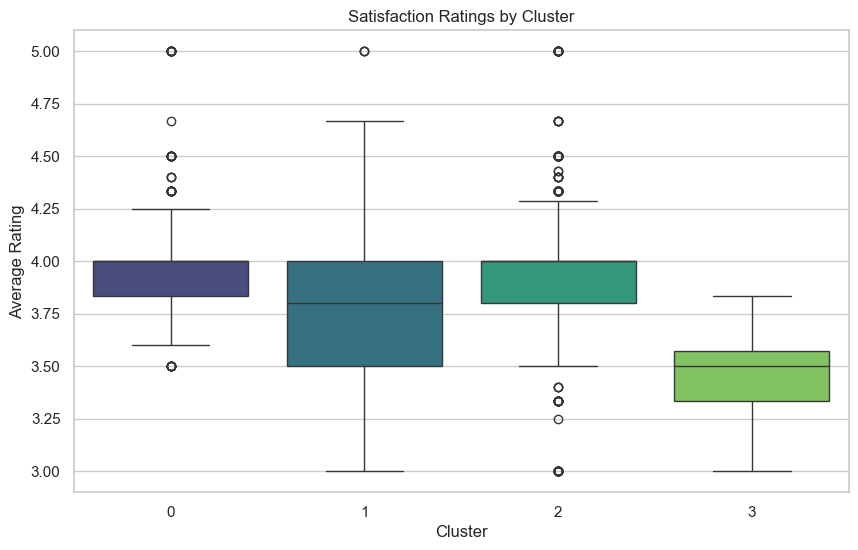

In [7]:
# Plot 1: Spending vs. Quality Expectations
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features_clean, x='avg_spend_per_night', y='quality_expectations', hue='Cluster', palette='viridis', alpha=0.8)
plt.title('Customer Segments: Spend vs. Expectations')
plt.xlabel('Average Spend per Night ($)')
plt.ylabel('Quality Expectations')
plt.legend(title='Cluster')
plt.show()

# Plot 2: Satisfaction Ratings by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=customer_features_clean, x='Cluster', y='avg_overall_rating', palette='viridis')
plt.title('Satisfaction Ratings by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Rating')
plt.show()

In [8]:
# Define the names based on the cluster characteristics
# (Note: Check your cluster output! The numbers 0,1,2,3 might swap if you change random_state)
cluster_names = {
    0: "Happy VIP (High Spend, High Sat)",
    1: "Standard Guest (Mid Spend, Mid Sat)",
    2: "Budget Explorer (Low Spend, Good Sat)",
    3: "At-Risk VIP (High Spend, Low Sat)"
}

customer_features_clean['Segment_Name'] = customer_features_clean['Cluster'].map(cluster_names)

# Show a sample of the final output
print(customer_features_clean[['customer_id', 'Cluster', 'Segment_Name']].head(10))

# Save to CSV if needed for the next step
customer_features_clean.to_csv('customer_segments_output.csv', index=False)

    customer_id  Cluster                           Segment_Name
2   CUST-000003        0       Happy VIP (High Spend, High Sat)
3   CUST-000004        0       Happy VIP (High Spend, High Sat)
4   CUST-000005        1    Standard Guest (Mid Spend, Mid Sat)
5   CUST-000006        2  Budget Explorer (Low Spend, Good Sat)
6   CUST-000007        2  Budget Explorer (Low Spend, Good Sat)
7   CUST-000008        2  Budget Explorer (Low Spend, Good Sat)
8   CUST-000009        2  Budget Explorer (Low Spend, Good Sat)
10  CUST-000011        1    Standard Guest (Mid Spend, Mid Sat)
12  CUST-000013        0       Happy VIP (High Spend, High Sat)
13  CUST-000014        3      At-Risk VIP (High Spend, Low Sat)


C:\Users\User\AppData\Local\Temp\ipykernel_21472\1777473933.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_features_clean['Segment_Name'] = customer_features_clean['Cluster'].map(cluster_names)


--- Model Performance ---
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       750
           1       0.95      0.96      0.95      1222
           2       0.92      0.94      0.93       587
           3       0.53      0.42      0.47       436

    accuracy                           0.83      2995
   macro avg       0.77      0.77      0.77      2995
weighted avg       0.82      0.83      0.82      2995


--- Cross-Validation ---
Scores for each run: [0.82337229 0.82804674 0.82003339 0.82237062 0.8246493 ]
Average Robust Accuracy: 82.37%

--- Feature Importance ---
loyalty_tier           0.235331
lead_time_days         0.225069
avg_daily_rate         0.200913
nights_stay            0.104207
room_type              0.073297
num_guests             0.063432
purpose_of_visit       0.041811
booking_channel        0.028522
season                 0.027417
has_special_request    0.000000
dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_12652\3152124569.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_imp.values, y=feature_imp.index, palette='viridis')


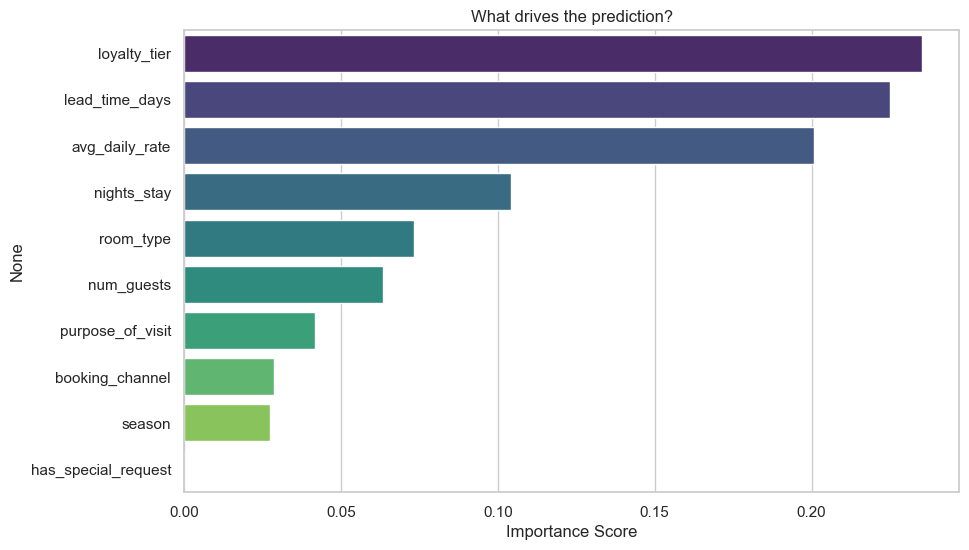

In [9]:
# ==========================================
# STEP 2: PREDICTIVE MODELING
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# 1. Prepare the Training Data
# We need to merge our Cluster labels back to the individual bookings.
# This gives us a dataset where every booking has a "Truth" label.
training_data = bookings_df.merge(
    customer_features_clean[['customer_id', 'Cluster']], 
    on='customer_id', 
    how='inner'
)

training_data['has_special_request'] = training_data['special_request'].apply(lambda x: 0 if x == 'None' else 1)

# 2. Select Features (Inputs)
# These must be things we know *before* the guest arrives.
predictor_columns = [
    'lead_time_days',   # How far in advance did they book?
    'nights_stay',      # Duration?
    'avg_daily_rate',   # Spend level?
    'num_guests',       # Solo, Couple, or Group?
    'room_type',        # Standard vs Suite?
    'season',           # Peak vs Off-peak?
    'booking_channel',  # App vs Agent?
    'purpose_of_visit', # Business vs Leisure?
    'loyalty_tier',      # Platinum vs None?
    'has_special_request'
]

X = training_data[predictor_columns].copy()
y = training_data['Cluster']

# 3. Encode Categorical Features
# Machine learning models need numbers, not text strings.
le_dict = {} # Dictionary to save our encoders for later use
categorical_cols = ['room_type', 'season', 'booking_channel', 'purpose_of_visit', 'loyalty_tier']

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

# 4. Split Data into Train and Test Sets
# We train on 80% of the data and test on the remaining 20% to see how good we are.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train the Model (Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# 6. Evaluate the Model
print("--- Model Performance ---")
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

from sklearn.model_selection import cross_val_score

# Run 5-fold Cross-Validation
# We use the full X and y here to see how the model performs on different chunks of data
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

print(f"\n--- Cross-Validation ---")
print(f"Scores for each run: {cv_scores}")
print(f"Average Robust Accuracy: {cv_scores.mean():.2%}")

# 7. Feature Importance (Explainability)
# This tells us WHICH factors drive the prediction (Crucial for the judges!)
importances = rf_model.feature_importances_
feature_imp = pd.Series(importances, index=predictor_columns).sort_values(ascending=False)

print("\n--- Feature Importance ---")
print(feature_imp)

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp.values, y=feature_imp.index, palette='viridis')
plt.title('What drives the prediction?')
plt.xlabel('Importance Score')
plt.show()

In [9]:
# ==========================================
# STEP 2 ENHANCED: PREDICTIVE MODELING
# ==========================================
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 1. Load Data (Safety check for encoding)
try:
    bookings_df = pd.read_csv('cinnamon_bookings.csv', encoding='ISO-8859-1')
    profiles_df = pd.read_csv('customers_profiles .csv', encoding='ISO-8859-1')
except:
    bookings_df = pd.read_csv('cinnamon_bookings.csv', encoding='cp1252')
    profiles_df = pd.read_csv('customers_profiles .csv', encoding='cp1252')

# Ensure we have the Cluster labels from Step 1
# (Assuming 'customer_features_clean' from Step 1 exists. If not, re-run Step 1)
training_data = bookings_df.merge(
    customer_features_clean[['customer_id', 'Cluster']], 
    on='customer_id', 
    how='inner'
)

# 2. THE FIX: Merge Customer Profile Data
# This adds the "Psychographic" features (Expectations, Sensitivity, etc.)
training_data = training_data.merge(profiles_df, on='customer_id', how='left')

# 3. Feature Engineering (Fix B)
training_data['has_special_request'] = training_data['special_request'].apply(lambda x: 0 if str(x) == 'None' else 1)

# 4. Select Features (Now including Profile Data!)
predictor_columns = [
    'lead_time_days', 'nights_stay', 'avg_daily_rate', 'num_guests',
    'room_type', 'season', 'booking_channel', 'purpose_of_visit', 'loyalty_tier',
    'has_special_request',
    # --- New Psychographic Features ---
    'age', 'gender', 'country', 
    'price_sensitivity', 'quality_expectations', 'travel_frequency',
    'spontaneity', 'social_orientation', 'income_level'
]


from sklearn.feature_selection import RFE

# Automatically select the top 10 best features
selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

print("Top Features selected by Algorithm:")
print(X_train.columns[selector.support_])



X = training_data[predictor_columns].copy()
y = training_data['Cluster']

# 5. Encode Categorical Features
le_dict = {}
categorical_cols = ['room_type', 'season', 'booking_channel', 'purpose_of_visit', 'loyalty_tier', 'gender', 'country']

for col in categorical_cols:
    le = LabelEncoder()
    # Handle any potential string/numeric mix
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Train Model (With Class Weighting)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# 8. Evaluate
print("--- Enhanced Model Performance ---")
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

# 9. Feature Importance Check
importances = rf_model.feature_importances_
feature_imp = pd.Series(importances, index=predictor_columns).sort_values(ascending=False)
print("\n--- Top 5 Drivers of Prediction ---")
print(feature_imp.head(5))

--- Enhanced Model Performance ---
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       750
           1       0.99      1.00      0.99      1222
           2       1.00      0.99      1.00       587
           3       0.90      0.81      0.85       436

    accuracy                           0.95      2995
   macro avg       0.95      0.93      0.94      2995
weighted avg       0.95      0.95      0.95      2995


--- Top 5 Drivers of Prediction ---
income_level            0.190759
quality_expectations    0.153751
price_sensitivity       0.120614
spontaneity             0.119170
loyalty_tier            0.087435
dtype: float64


In [11]:
# ==========================================
# DEMO: PREDICTING FOR A NEW BOOKING (ENHANCED)
# ==========================================
import pandas as pd

# 1. Define the New Booking (Now with Profile Data!)
new_booking = {
    # --- Booking Details ---
    'lead_time_days': [14],
    'nights_stay': [2],
    'avg_daily_rate': [180],
    'num_guests': [2],
    'room_type': ['Standard'],
    'season': ['Off-Peak'],
    'booking_channel': ['Mobile App'],
    'purpose_of_visit': ['Business'],
    'loyalty_tier': ['Silver'],
    'special_request': ['None'], 
    
    # --- REQUIRED: Profile Data (The Agent fetches this from DB) ---
    'age': [34],
    'gender': ['Female'],         # <--- This caused your error before
    'country': ['Australia'],
    'price_sensitivity': [0.4],   # Low sensitivity (Willing to pay)
    'quality_expectations': [0.9],# High expectations (Likely VIP)
    'travel_frequency': [8],
    'spontaneity': [0.2],
    'social_orientation': [0.5],
    'income_level': [0.8]
}

# 2. Convert to DataFrame
new_booking_df = pd.DataFrame(new_booking)

# 3. Apply Feature Engineering (SAME as Training)
# We created this manual feature in Step 2, so we must create it here too
new_booking_df['has_special_request'] = new_booking_df['special_request'].apply(lambda x: 0 if str(x) == 'None' else 1)

# 4. Apply Encoding (SAME as Training)
# We use the 'le_dict' we saved during training to translate text -> numbers
for col in categorical_cols:
    if col in new_booking_df.columns:
        # Check if the value was seen during training
        if new_booking_df[col].iloc[0] in le_dict[col].classes_:
            new_booking_df[col] = le_dict[col].transform(new_booking_df[col])
        else:
            # Handle unseen labels (e.g., a new Country) by assigning a default
            print(f"Warning: Unseen label in {col}. Assigning default.")
            new_booking_df[col] = 0 
    else:
        print(f"Error: Missing column {col}")

# 5. Predict!
predicted_cluster = rf_model.predict(new_booking_df[predictor_columns])[0]

# Map back to names (Ensure these match your Cluster Map from Step 1)
cluster_names = {
    0: "Happy VIP",
    1: "Standard Guest",
    2: "Budget Explorer",
    3: "At-Risk VIP"
}

print(f"--- Agentic Insight ---")
print(f"Guest: {new_booking['gender'][0]} from {new_booking['country'][0]}")
print(f"Predicted Segment: {cluster_names.get(predicted_cluster, 'Unknown')} (Cluster {predicted_cluster})")

# 6. Agentic Action Trigger
if predicted_cluster == 3: 
    print("\n[ALERT] High-Value At-Risk Guest detected!")
    print("ACTION: Notify Guest Relations. Pre-assign 'Quiet Room'. Draft 'Welcome' email with complimentary upgrade offer.")
elif predicted_cluster == 0:
    print("\n[INFO] VIP Guest detected.")
    print("ACTION: Send 'Exclusive Dining' menu.")
else:
    print("\n[INFO] Standard booking processed.")

--- Agentic Insight ---
Guest: Female from Australia
Predicted Segment: Happy VIP (Cluster 0)

[INFO] VIP Guest detected.
ACTION: Send 'Exclusive Dining' menu.


In [12]:
# ==========================================
# STEP 3: AGENTIC SYSTEM IMPLEMENTATION
# ==========================================
import pandas as pd
import datetime

# 1. Load Knowledge Base (The "Tools" for the Agent)
events_df = pd.read_csv('local_events.csv')
hotels_df = pd.read_csv('cinnamon_hotels_catalog .csv')

# 2. Define Agent Capabilities
def get_mock_weather(date_str):
    """Simulates checking a Weather API based on the month"""
    try:
        dt = pd.to_datetime(date_str)
        month = dt.month
        if month in [5, 6, 9, 10, 11]: return "Rainy, 28°C" # Monsoon season
        elif month in [12, 1, 2, 3]: return "Sunny, 30°C"   # Peak season
        else: return "Cloudy, 29°C"
    except:
        return "Sunny, 30°C"

def get_agent_context(hotel_name, check_in_date, check_out_date):
    """Retrieves Hotel Features + Local Events + Weather"""
    context = {}
    
    # A. Retrieve Hotel Features
    try:
        hotel_info = hotels_df[hotels_df['hotel_branch'] == hotel_name].iloc[0]
        context['features'] = []
        if hotel_info['has_spa']: context['features'].append("Luxury Spa")
        if hotel_info['has_pool']: context['features'].append("Infinity Pool")
        context['offer'] = hotel_info['current_offer']
    except:
        context['features'] = ["General Amenities"]
        context['offer'] = "None"

    # B. Retrieve Local Events (Check for date overlap)
    stay_start = pd.to_datetime(check_in_date)
    stay_end = pd.to_datetime(check_out_date)
    
    relevant_events = []
    for _, event in events_df.iterrows():
        try:
            event_start = pd.to_datetime(event['start'])
            event_end = pd.to_datetime(event['end'])
            if (stay_start <= event_end) and (stay_end >= event_start):
                relevant_events.append(event['event'])
        except: pass
            
    context['events'] = relevant_events if relevant_events else ["a quiet relaxing time"]
    
    # C. Retrieve Weather
    context['weather'] = get_mock_weather(check_in_date)
    
    return context

def generate_agentic_email(guest_name, segment, context, booking_details):
    """Composes the email based on Segment + Context"""
    
    hotel_name = booking_details['hotel_name']
    events_str = ", ".join(context['events'])
    feature = context['features'][0] if context['features'] else "facilities"
    
    # --- DYNAMIC TEMPLATE SELECTION ---
    
    if segment == "At-Risk VIP":
        # Strategy: Apologetic tone, reassurance, high-value upgrade
        subject = f"✨ Personal Priority: Your upcoming stay at {hotel_name}"
        body = f"""
Dear {guest_name},

We noticed your upcoming booking on {booking_details['check_in_date']}, and I wanted to personally reach out.
Because you are one of our most valued guests, I have alerted our team to assign you a quiet, premium room.

Context Update:
The weather is forecast to be {context['weather']}—perfect for unwinding at our {feature}.
Since it is {events_str} season, the city will be lively!

Your Exclusive Offer:
To ensure your stay is flawless, we have applied a special offer: {context['offer']}.

Warm regards,
AI Concierge Manager
"""

    elif segment == "Budget Explorer":
        # Strategy: Fun tone, value-focused, free activities
        subject = f"Ready for your adventure at {hotel_name}?"
        body = f"""
Hi {guest_name}!

We can't wait to see you on {booking_details['check_in_date']}.
Did you know? Our {feature} is open to all guests!

Local Tip:
{events_str} is happening nearby! It's a great way to experience the culture for free.
Weather looks {context['weather']}, so pack accordingly!

Check out our Happy Hour deals at the bar upon arrival.

Cheers,
Team {hotel_name}
"""

    elif segment == "Happy VIP":
        # Strategy: Recognition, consistency, upsell
        subject = f"Welcome Back to {hotel_name}!"
        body = f"""
Dear {guest_name},

It is a pleasure to welcome you back. Your usual preferences have been noted.
As always, our {feature} is available for your relaxation.

We hope you enjoy the {events_str} festivities during your stay.

Your Loyalty Perk: {context['offer']}.

Best,
Guest Relations
"""

    else: # Standard
        subject = f"Your stay at {hotel_name}"
        body = f"""
Dear {guest_name},

We look forward to hosting you on {booking_details['check_in_date']}.
Enjoy our {feature} and have a wonderful time.

Weather: {context['weather']}
Events: {events_str}

Safe travels,
{hotel_name}
"""

    return subject, body

# --- DEMO THE AGENT ---
# Let's run this for the guest we analyzed in Step 2!
# (Assuming we identified an "At-Risk VIP" named Mr. Perera)

demo_booking = {
    'hotel_name': 'Cinnamon Grand Colombo',
    'check_in_date': '12/25/2025', 
    'check_out_date': '12/28/2025'
}
demo_segment = "At-Risk VIP" # The output from Step 2

# 1. Agent "Thinks" (Retrieves Context)
ctx = get_agent_context(demo_booking['hotel_name'], demo_booking['check_in_date'], demo_booking['check_out_date'])

# 2. Agent "Acts" (Writes Email)
subj, email = generate_agentic_email("Mr. Perera", demo_segment, ctx, demo_booking)

print("--- AGENTIC SYSTEM DEMO ---")
print(f"DETECTED SEGMENT: {demo_segment}")
print(f"CONTEXT RETRIEVED: {ctx}")
print("-" * 40)
print(f"SUBJECT: {subj}")
print(email)

--- AGENTIC SYSTEM DEMO ---
DETECTED SEGMENT: At-Risk VIP
CONTEXT RETRIEVED: {'features': ['Luxury Spa', 'Infinity Pool'], 'offer': 'Spa Discount 20%', 'events': ['a quiet relaxing time'], 'weather': 'Sunny, 30°C'}
----------------------------------------
SUBJECT: ✨ Personal Priority: Your upcoming stay at Cinnamon Grand Colombo

Dear Mr. Perera,

We noticed your upcoming booking on 12/25/2025, and I wanted to personally reach out.
Because you are one of our most valued guests, I have alerted our team to assign you a quiet, premium room.

Context Update:
The weather is forecast to be Sunny, 30°C—perfect for unwinding at our Luxury Spa.
Since it is a quiet relaxing time season, the city will be lively!

Your Exclusive Offer:
To ensure your stay is flawless, we have applied a special offer: Spa Discount 20%.

Warm regards,
AI Concierge Manager



In [13]:
import pickle

# 1. Create a "Deployment Package"
# We save not just the model, but the column names and encoders 
# to ensure the app works EXACTLY like the notebook.
deployment_package = {
    'kmeans_model': kmeans,            # The Step 1 Clustering Model
    'scaler': scaler,                  # The Scaler for Step 1
    'rf_model': rf_model,              # The Step 2 Prediction Model
    'le_dict': le_dict,                # The Encoders (Text -> Numbers)
    'cluster_names': cluster_names,    # The Mapping (0 -> Happy VIP)
    'step1_features': features_to_use, # List of cols for Clustering
    'step2_features': predictor_columns, # List of cols for Prediction
    'categorical_cols': categorical_cols, # List of text cols
    'labeled_data': customer_features_clean # The result of Step 1
}

# 2. Save to disk
with open('cinnamon_ai_brain.pkl', 'wb') as f:
    pickle.dump(deployment_package, f)

print("✅ Success! 'cinnamon_ai_brain.pkl' saved. Move this file to your App folder.")

✅ Success! 'cinnamon_ai_brain.pkl' saved. Move this file to your App folder.
